In [ ]:
# Install gdown to download from Google Drive
!pip install -q gdown

# Step 1: Define the file ID and output name
file_id = "1OSifYnXjjwAxSO2Vm7r55bOXJ9oekkNY"
output_name = "tweet_sets.zip"

# Step 2: Download the file using gdown
import gdown

print("Downloading file from Google Drive...")
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_name, quiet=False)

# Step 3: Unzip the file in the current directory
import zipfile
import os

print("Unzipping the downloaded file...")
with zipfile.ZipFile(output_name, 'r') as zip_ref:
    zip_ref.extractall("./")

print("✅ Dataset has been downloaded and extracted to the current folder.")


Downloading...
From: https://drive.google.com/uc?id=1OSifYnXjjwAxSO2Vm7r55bOXJ9oekkNY
To: /content/tweet_sets.zip
100%|██████████| 1.53M/1.53M [00:00<00:00, 13.2MB/s]

Unzipping the downloaded file...
✅ Dataset has been downloaded and extracted to the current folder.


Step 1: Loaded paired image-text embeddings
  sample_id                                    image_embedding  \
0  sample_0  [0.8593245105473037, 0.026912186138423833, 0.5...   
1  sample_1  [0.755706906791908, 0.2037165091594516, 0.1557...   
2  sample_2  [0.10629589911154336, 0.22962056402253272, 0.0...   
3  sample_3  [0.8192324933745518, 0.9721885802331712, 0.679...   
4  sample_4  [0.4552394315167726, 0.4237989667213733, 0.416...   

                                      text_embedding  
0  [0.09342191087348639, 0.6188978731201021, 0.45...  
1  [0.05241859723997688, 0.5004639826075532, 0.02...  
2  [0.4590168373246244, 0.04218154264965557, 0.49...  
3  [0.1633111325954134, 0.9194939014323453, 0.177...  
4  [0.8396072824806978, 0.8860270077963378, 0.509...  

Processing Sample ID: sample_0
Resolution 1x1 similarity matrix:
[[0.75021644]]
Resolution 2x2 similarity matrix:
[[0.76207231 0.76742503]
 [0.75669312 0.73776578]]
Resolution 4x4 similarity matrix:
[[0.74656919 0.70931202 0.766

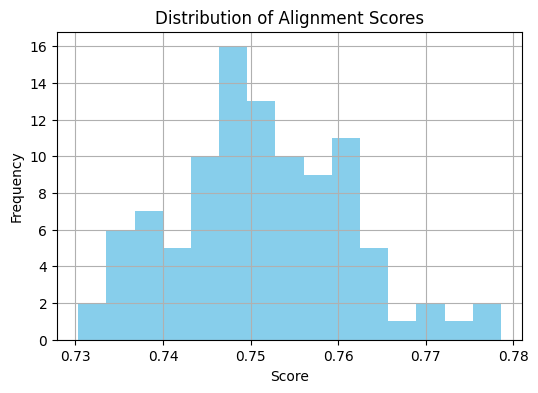

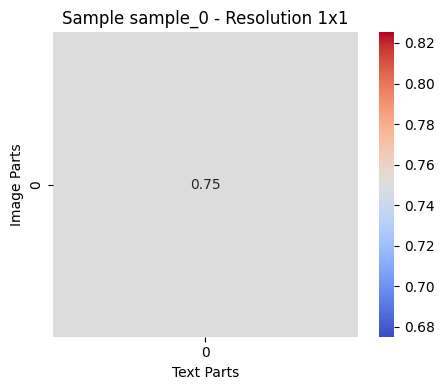

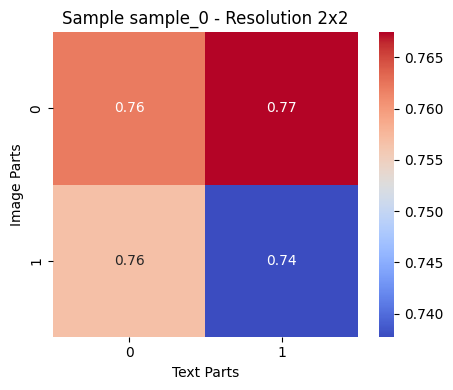

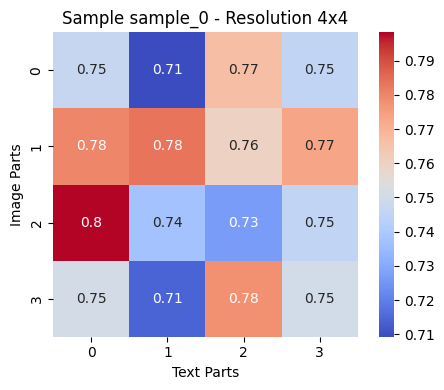

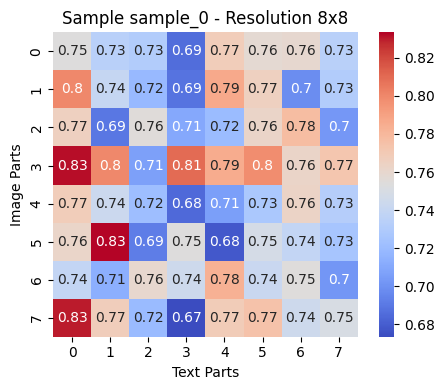

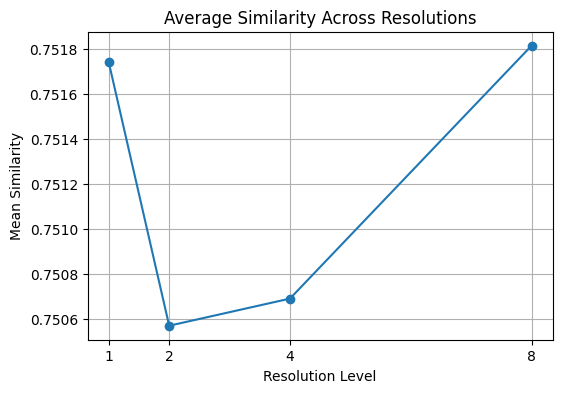

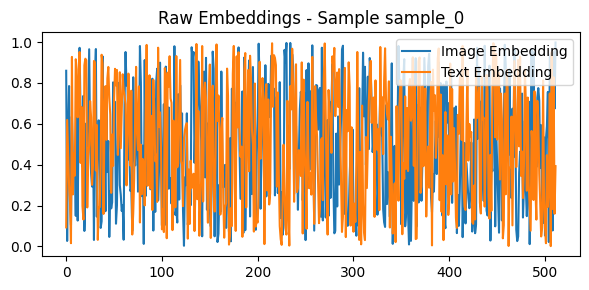


All plots saved in current directory.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

# Ensure output directory exists
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Function to safely parse stringified lists from CSV
def parse_embedding(embedding_str):
    return np.array(ast.literal_eval(embedding_str))

# Step 1: Load paired image-text embeddings
df = pd.read_csv('image_text_embeddings.csv')
print("Step 1: Loaded paired image-text embeddings")
print(df.head())

# Parse the embedding strings into numpy arrays
df['image_embedding'] = df['image_embedding'].apply(parse_embedding)
df['text_embedding'] = df['text_embedding'].apply(parse_embedding)

# Define resolution levels
def split_embedding(embedding, level):
    """
    Splits embedding vector into specified number of segments.
    """
    return np.array_split(embedding, level)

# Cosine similarity function
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Step 2: Compute multiresolution similarity matrices
alignment_scores = []
all_similarity_matrices = []

for idx, row in df.iterrows():
    image_embed = row['image_embedding']
    text_embed = row['text_embedding']

    similarity_results = {}

    print(f"\nProcessing Sample ID: {row['sample_id']}")

    for level in [1, 2, 4, 8]:  # Multiresolution from global to token-level
        img_parts = split_embedding(image_embed, level)
        txt_parts = split_embedding(text_embed, level)

        sim_matrix = np.zeros((level, level))
        for i in range(level):
            for j in range(level):
                sim_matrix[i, j] = cosine_similarity(img_parts[i], txt_parts[j])

        similarity_results[f'resolution_{level}'] = sim_matrix
        all_similarity_matrices.append({
            'sample_id': row['sample_id'],
            'resolution': level,
            'similarity_matrix': sim_matrix
        })

        print(f"Resolution {level}x{level} similarity matrix:")
        print(sim_matrix)

    # Step 3: Aggregate alignment score
    alignment_score = 0
    for level in [1, 2, 4, 8]:
        score = np.mean(similarity_results[f'resolution_{level}'])
        alignment_score += score
    alignment_score /= 4

    alignment_scores.append({
        'sample_id': row['sample_id'],
        'alignment_score': alignment_score
    })
    print(f"Final Multiresolution Alignment Score: {alignment_score:.4f}")

# Step 4: Save results to CSV
alignment_df = pd.DataFrame(alignment_scores)
alignment_df.to_csv(os.path.join(output_dir, 'alignment_scores.csv'), index=False)
print("\nSaved alignment scores to alignment_scores.csv")

# Save similarity matrices for all samples
sim_matrix_data = []
for entry in all_similarity_matrices:
    matrix_flat = entry['similarity_matrix'].flatten()
    sim_matrix_data.append([entry['sample_id'], entry['resolution']] + matrix_flat.tolist())

sim_matrix_cols = ['sample_id', 'resolution'] + [f'cell_{i}' for i in range(len(matrix_flat))]
sim_df = pd.DataFrame(sim_matrix_data, columns=sim_matrix_cols)
sim_df.to_csv(os.path.join(output_dir, 'similarity_matrices.csv'), index=False)
print("Saved similarity matrices to similarity_matrices.csv")

# Step 5: Plot embeddings and similarity heatmaps
# Plot 1: Histogram of alignment scores
plt.figure(figsize=(6, 4))
plt.hist(alignment_df['alignment_score'], bins=15, color='skyblue')
plt.title('Distribution of Alignment Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot1_alignment_score_histogram.png'))
plt.show()

# Plot 2–5: Similarity heatmaps at different resolutions for first sample
first_sample = df.iloc[0]
image_embed = first_sample['image_embedding']
text_embed = first_sample['text_embedding']
sample_id = first_sample['sample_id']

for level in [1, 2, 4, 8]:
    img_parts = split_embedding(image_embed, level)
    txt_parts = split_embedding(text_embed, level)
    sim_matrix = np.zeros((level, level))
    for i in range(level):
        for j in range(level):
            sim_matrix[i, j] = cosine_similarity(img_parts[i], txt_parts[j])
    plt.figure(figsize=(5, 4))
    sns.heatmap(sim_matrix, annot=True, cmap="coolwarm", square=True)
    plt.title(f'Sample {sample_id} - Resolution {level}x{level}')
    plt.xlabel('Text Parts')
    plt.ylabel('Image Parts')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'plot_resolution_{level}.png'))
    plt.show()

# Plot 6: Line plot of average alignment score per resolution
res_levels = [1, 2, 4, 8]
res_means = []
for level in res_levels:
    scores = []
    for entry in all_similarity_matrices:
        if entry['resolution'] == level:
            sim = entry['similarity_matrix']
            scores.append(np.mean(sim))
    res_means.append(np.mean(scores))

plt.figure(figsize=(6, 4))
plt.plot(res_levels, res_means, marker='o')
plt.xticks(res_levels)
plt.xlabel("Resolution Level")
plt.ylabel("Mean Similarity")
plt.title("Average Similarity Across Resolutions")
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot_resolution_score_curve.png'))
plt.show()

# Plot 7–8: Raw embeddings (first sample) for visual inspection
plt.figure(figsize=(6, 3))
plt.plot(image_embed, label='Image Embedding')
plt.plot(text_embed, label='Text Embedding')
plt.title(f'Raw Embeddings - Sample {sample_id}')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'plot_embeddings_sample0.png'))
plt.show()

print("\nAll plots saved in current directory.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import random
import os

# Ensure output directory exists
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Function to parse stringified list embeddings
def parse_embedding(embedding_str):
    return np.array(ast.literal_eval(embedding_str))

# Load the original tweet embeddings
df = pd.read_csv('original_tweet_embeddings.csv')
print("Step 1: Loaded original tweet embeddings")
print(df.head())

# Convert string embeddings to numpy arrays
df['current_embedding'] = df['current_embedding'].apply(parse_embedding)

# Cosine similarity function
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Step 2: Generate adversarial perturbations
def generate_adversarial_embedding(embedding, epsilon=0.1):
    """Applies bounded noise to create an adversarial view."""
    noise = np.random.normal(0, epsilon, embedding.shape)
    adversarial_embedding = embedding + noise
    return adversarial_embedding

# Process each tweet: generate perturbation and compute consistency
adversarial_results = []

for idx, row in df.iterrows():
    tweet_id = row['tweet_id']
    original_embed = row['current_embedding']

    print(f"\nProcessing Tweet ID: {tweet_id}")
    adversarial_embed = generate_adversarial_embedding(original_embed)

    # Compute contrastive consistency (cosine similarity)
    similarity = cosine_similarity(original_embed, adversarial_embed)

    print("Original embedding (first 5 dims):", original_embed[:5])
    print("Adversarial embedding (first 5 dims):", adversarial_embed[:5])
    print(f"Contrastive Consistency Score: {similarity:.4f}")

    adversarial_results.append({
        'tweet_id': tweet_id,
        'original_embedding': original_embed,
        'adversarial_embedding': adversarial_embed,
        'consistency_score': similarity
    })

# Step 3: Save results to CSV
result_df = pd.DataFrame({
    'tweet_id': [r['tweet_id'] for r in adversarial_results],
    'consistency_score': [r['consistency_score'] for r in adversarial_results],
    'original_embedding': [r['original_embedding'].tolist() for r in adversarial_results],
    'adversarial_embedding': [r['adversarial_embedding'].tolist() for r in adversarial_results]
})
result_df.to_csv(os.path.join(output_dir, 'adversarial_consistency_scores.csv'), index=False)
print("\nSaved adversarial consistency scores to adversarial_consistency_scores.csv")

# Step 4: Visualization

# Plot 1: Histogram of consistency scores
plt.figure(figsize=(6, 4))
plt.hist(result_df['consistency_score'], bins=20, color='salmon')
plt.title('Distribution of Contrastive Consistency Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot1_consistency_score_histogram.png'))
plt.show()

# Plot 2: Boxplot of consistency scores
plt.figure(figsize=(5, 4))
sns.boxplot(y=result_df['consistency_score'], color='lightblue')
plt.title('Boxplot of Consistency Scores')
plt.ylabel('Cosine Similarity')
plt.savefig(os.path.join(output_dir, 'plot2_consistency_score_boxplot.png'))
plt.show()

# Plot 3–4: Embedding distribution before and after perturbation (first sample)
sample = adversarial_results[0]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(sample['original_embedding'], label='Original')
plt.title(f'Tweet {sample["tweet_id"]} - Original Embedding')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sample['adversarial_embedding'], label='Adversarial', color='orange')
plt.title(f'Tweet {sample["tweet_id"]} - Adversarial Embedding')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'plot3_4_embeddings_sample0.png'))
plt.show()

# Plot 5: Line plot comparing original and adversarial embeddings (zoomed)
plt.figure(figsize=(8, 4))
plt.plot(sample['original_embedding'][:50], label='Original')
plt.plot(sample['adversarial_embedding'][:50], label='Adversarial', linestyle='--')
plt.title(f'Original vs Adversarial (First 50 Dimensions) - {sample["tweet_id"]}')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot5_embedding_comparison_zoomed.png'))
plt.show()

# Plot 6: Scatter of original vs adversarial (first sample, 2D projection)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = np.vstack([sample['original_embedding'], sample['adversarial_embedding']])
X_reduced = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
plt.scatter(X_reduced[0, 0], X_reduced[0, 1], color='blue', label='Original')
plt.scatter(X_reduced[1, 0], X_reduced[1, 1], color='red', label='Adversarial')
plt.title(f'PCA Projection of Embeddings - Tweet {sample["tweet_id"]}')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot6_pca_projection.png'))
plt.show()

# Plot 7–8: Consistency score trend across samples
plt.figure(figsize=(7, 4))
plt.plot(result_df['consistency_score'].values, marker='o', linestyle='-', color='green')
plt.title('Consistency Scores Across Tweets')
plt.xlabel('Tweet Index')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot7_score_trend.png'))
plt.show()

plt.figure(figsize=(6, 4))
sns.violinplot(y=result_df['consistency_score'], color='lightgreen')
plt.title('Violin Plot of Consistency Scores')
plt.savefig(os.path.join(output_dir, 'plot8_score_violin.png'))
plt.show()

print("\nAll plots and outputs are saved in the current directory.")


Step 1: Loaded original tweet embeddings
  tweet_id                                       tweet_text  \
0  tweet_0  This is a sample tweet 0 with some information.   
1  tweet_1  This is a sample tweet 1 with some information.   
2  tweet_2  This is a sample tweet 2 with some information.   
3  tweet_3  This is a sample tweet 3 with some information.   
4  tweet_4  This is a sample tweet 4 with some information.   

            image_path                                  current_embedding  
0  /images/image_0.jpg  [0.3688758363239997, 0.5245513075853206, 0.118...  
1  /images/image_1.jpg  [0.6403964041103389, 0.2925430231071612, 0.225...  
2  /images/image_2.jpg  [0.5257903221423885, 0.9346596855522742, 0.761...  
3  /images/image_3.jpg  [0.40421647076018397, 0.47660536475708093, 0.5...  
4  /images/image_4.jpg  [0.8070013537409257, 0.7454135707969516, 0.297...  

Processing Tweet ID: tweet_0
Original embedding (first 5 dims): [0.36887584 0.52455131 0.11826045 0.78619813 0.79478119]
Ad

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import hashlib

# Constants
EMBEDDING_DIM = 256
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Function to generate a pseudo-embedding from text using a hash
def generate_embedding(text, dim=EMBEDDING_DIM):
    hash_digest = hashlib.sha256(text.encode()).digest()
    seed = int.from_bytes(hash_digest[:4], 'big')
    rng = np.random.default_rng(seed)
    return rng.normal(0, 1, dim)

# Cosine similarity function
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Step 1: Load the temporally shifted tweet dataset
df = pd.read_csv('temporal_tweet_versions.csv')
print("Step 1: Loaded temporally shifted tweet data")
print(df.head())

# Step 2: Generate embeddings per tweet version
print("\nStep 2: Generating embeddings per tweet version...")
df['embedding'] = df['tweet_text'].apply(lambda x: generate_embedding(x).tolist())

# Step 3: Compute temporal similarity matrices
sequences = df['sequence_id'].unique()
temporal_results = []
similarity_matrices = []

for seq_id in sequences:
    group = df[df['sequence_id'] == seq_id].sort_values('timestamp')
    embeddings = group['embedding'].apply(np.array).tolist()
    version_ids = group['version_id'].tolist()

    n = len(embeddings)
    sim_matrix = np.zeros((n, n))

    print(f"\nProcessing Sequence: {seq_id} with {n} versions")

    # Fill similarity matrix
    for i in range(n):
        for j in range(n):
            sim_matrix[i, j] = cosine_similarity(embeddings[i], embeddings[j])

    # Compute deviation score: average deviation from identity matrix
    ideal = np.eye(n)
    deviation = np.abs(sim_matrix - ideal).mean()

    temporal_results.append({
        'sequence_id': seq_id,
        'num_versions': n,
        'deviation_score': deviation
    })

    similarity_matrices.append({
        'sequence_id': seq_id,
        'version_ids': version_ids,
        'similarity_matrix': sim_matrix
    })

    print("Similarity matrix:")
    print(np.round(sim_matrix, 3))
    print(f"Deviation Score: {deviation:.4f}")

# Step 4: Save results to CSV
deviation_df = pd.DataFrame(temporal_results)
deviation_df.to_csv(os.path.join(output_dir, 'temporal_deviation_scores.csv'), index=False)
print("\nSaved deviation scores to temporal_deviation_scores.csv")

# Save similarity matrices
matrix_data = []
for entry in similarity_matrices:
    flat_matrix = entry['similarity_matrix'].flatten().tolist()
    matrix_data.append([entry['sequence_id']] + flat_matrix)

max_len = max(len(m) for m in matrix_data)
for row in matrix_data:
    while len(row) < max_len:
        row.append("")

col_names = ['sequence_id'] + [f'cell_{i}' for i in range(max_len - 1)]
sim_df = pd.DataFrame(matrix_data, columns=col_names)
sim_df.to_csv(os.path.join(output_dir, 'temporal_similarity_matrices.csv'), index=False)
print("Saved similarity matrices to temporal_similarity_matrices.csv")

# Step 5: Plots

# Plot 1: Histogram of deviation scores
plt.figure(figsize=(6, 4))
plt.hist(deviation_df['deviation_score'], bins=10, color='skyblue')
plt.title('Distribution of Temporal Deviation Scores')
plt.xlabel('Deviation Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot1_deviation_histogram.png'))
plt.show()

# Plot 2: Boxplot of deviation scores
plt.figure(figsize=(4, 5))
sns.boxplot(y=deviation_df['deviation_score'], color='lightgreen')
plt.title('Boxplot of Temporal Deviation Scores')
plt.ylabel('Deviation Score')
plt.savefig(os.path.join(output_dir, 'plot2_deviation_boxplot.png'))
plt.show()

# Plot 3–6: Heatmaps for first few sequences
for idx, entry in enumerate(similarity_matrices[:4]):
    sim_matrix = entry['similarity_matrix']
    plt.figure(figsize=(5, 4))
    sns.heatmap(sim_matrix, annot=True, cmap="YlGnBu", square=True)
    plt.title(f'Sequence {entry["sequence_id"]} - Similarity Matrix')
    plt.xlabel('Version')
    plt.ylabel('Version')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'plot_heatmap_seq_{idx}.png'))
    plt.show()

# Plot 7: Deviation score trend by sequence index
plt.figure(figsize=(7, 4))
plt.plot(deviation_df['deviation_score'], marker='o', linestyle='-', color='orange')
plt.title('Deviation Score Across Sequences')
plt.xlabel('Sequence Index')
plt.ylabel('Deviation Score')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot7_deviation_trend.png'))
plt.show()

# Plot 8: Violin plot of deviation scores
plt.figure(figsize=(6, 4))
sns.violinplot(y=deviation_df['deviation_score'], color='lightcoral')
plt.title('Violin Plot of Deviation Scores')
plt.ylabel('Deviation Score')
plt.savefig(os.path.join(output_dir, 'plot8_violin.png'))
plt.show()

print("\nAll outputs and visualizations saved.")


Step 1: Loaded temporally shifted tweet data
  sequence_id version_id            timestamp  \
0       seq_0  version_0  2025-07-22 16:35:44   
1       seq_0  version_1  2025-07-22 22:35:44   
2       seq_0  version_2  2025-07-23 04:35:44   
3       seq_0  version_3  2025-07-23 10:35:44   
4       seq_0  version_4  2025-07-23 16:35:44   

                                          tweet_text  
0  Version 0 of event 0 with update at 2025-07-22...  
1  Version 1 of event 0 with update at 2025-07-22...  
2  Version 2 of event 0 with update at 2025-07-23...  
3  Version 3 of event 0 with update at 2025-07-23...  
4  Version 4 of event 0 with update at 2025-07-23...  

Step 2: Generating embeddings per tweet version...

Processing Sequence: seq_0 with 5 versions
Similarity matrix:
[[ 1.     0.083  0.076  0.024  0.014]
 [ 0.083  1.     0.07  -0.048  0.001]
 [ 0.076  0.07   1.     0.031 -0.019]
 [ 0.024 -0.048  0.031  1.     0.009]
 [ 0.014  0.001 -0.019  0.009  1.   ]]
Deviation Score: 0.0300


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os

# Set output directory
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Helper function to parse nested list (attention maps)
def parse_attention_map(map_str):
    return np.array(ast.literal_eval(map_str))

# Load image-text attention data
df = pd.read_csv('attention_maps.csv')
print("Step 1: Loaded attention maps dataset")
print(df.head())

# Parse attention map column into actual 2D numpy arrays
df['attention_map'] = df['attention_map'].apply(parse_attention_map)

# Entropy calculator for attention maps
def attention_entropy(matrix):
    flat = matrix.flatten()
    normalized = flat / np.sum(flat)
    normalized = np.clip(normalized, 1e-10, 1)  # Avoid log(0)
    return -np.sum(normalized * np.log2(normalized))

# Anomaly score: deviation from uniform + entropy
def compute_anomaly_score(att_map):
    entropy_val = attention_entropy(att_map)
    uniform_map = np.ones_like(att_map) / att_map.size
    deviation = np.abs(att_map - uniform_map).mean()
    return entropy_val + deviation

# Process each pair and compute anomaly score and saliency mask
results = []

for idx, row in df.iterrows():
    pair_id = row['pair_id']
    att_map = row['attention_map']
    entropy_val = attention_entropy(att_map)
    score = compute_anomaly_score(att_map)

    # Generate saliency mask: normalize attention values
    norm_map = (att_map - np.min(att_map)) / (np.max(att_map) - np.min(att_map))

    print(f"\nProcessing Pair ID: {pair_id}")
    print(f"Attention Entropy: {entropy_val:.4f}")
    print(f"Anomaly Field Score: {score:.4f}")

    results.append({
        'pair_id': pair_id,
        'attention_entropy': entropy_val,
        'anomaly_field_score': score,
        'saliency_mask': norm_map.tolist()
    })

# Step 4: Save results
result_df = pd.DataFrame({
    'pair_id': [r['pair_id'] for r in results],
    'attention_entropy': [r['attention_entropy'] for r in results],
    'anomaly_field_score': [r['anomaly_field_score'] for r in results],
    'saliency_mask': [r['saliency_mask'] for r in results]
})
result_df.to_csv(os.path.join(output_dir, 'camfa_outputs.csv'), index=False)
print("\nSaved anomaly field scores and saliency masks to camfa_outputs.csv")

# Step 5: Visualization

# Plot 1: Histogram of anomaly field scores
plt.figure(figsize=(6, 4))
plt.hist(result_df['anomaly_field_score'], bins=15, color='steelblue')
plt.title('Distribution of Anomaly Field Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot1_anomaly_score_histogram.png'))
plt.show()

# Plot 2: Boxplot of entropy values
plt.figure(figsize=(5, 4))
sns.boxplot(y=result_df['attention_entropy'], color='gold')
plt.title('Attention Entropy Distribution')
plt.ylabel('Entropy (bits)')
plt.savefig(os.path.join(output_dir, 'plot2_entropy_boxplot.png'))
plt.show()

# Plot 3–6: Visual saliency heatmaps of attention and mask
for idx in range(min(4, len(results))):
    pair_id = results[idx]['pair_id']
    saliency_mask = np.array(results[idx]['saliency_mask'])
    original_map = df[df['pair_id'] == pair_id]['attention_map'].values[0]

    # Original Attention Map
    plt.figure(figsize=(5, 4))
    sns.heatmap(original_map, cmap="Blues", annot=False, square=True)
    plt.title(f'Original Attention - Pair {pair_id}')
    plt.savefig(os.path.join(output_dir, f'plot_attmap_pair_{idx}.png'))
    plt.show()

    # Saliency Mask
    plt.figure(figsize=(5, 4))
    sns.heatmap(saliency_mask, cmap="Reds", annot=False, square=True)
    plt.title(f'Saliency Mask - Pair {pair_id}')
    plt.savefig(os.path.join(output_dir, f'plot_saliency_pair_{idx}.png'))
    plt.show()

# Plot 7: Anomaly score trend
plt.figure(figsize=(7, 4))
plt.plot(result_df['anomaly_field_score'], marker='o', linestyle='-', color='green')
plt.title('Anomaly Field Scores Across Pairs')
plt.xlabel('Pair Index')
plt.ylabel('Anomaly Score')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot7_anomaly_score_trend.png'))
plt.show()

# Plot 8: Violin plot of anomaly scores
plt.figure(figsize=(6, 4))
sns.violinplot(y=result_df['anomaly_field_score'], color='lightcoral')
plt.title('Violin Plot of Anomaly Field Scores')
plt.ylabel('Anomaly Score')
plt.savefig(os.path.join(output_dir, 'plot8_anomaly_score_violin.png'))
plt.show()

print("\nAll anomaly scores, masks, and plots saved successfully.")


Step 1: Loaded attention maps dataset
  pair_id                                      text           image_path  \
0  pair_0  Sample tweet 0 related to image content.  /images/image_0.jpg   
1  pair_1  Sample tweet 1 related to image content.  /images/image_1.jpg   
2  pair_2  Sample tweet 2 related to image content.  /images/image_2.jpg   
3  pair_3  Sample tweet 3 related to image content.  /images/image_3.jpg   
4  pair_4  Sample tweet 4 related to image content.  /images/image_4.jpg   

                                       attention_map  
0  [[0.9375468690267422, 0.6893538429372502, 0.53...  
1  [[0.7588865596013121, 0.38584755376518354, 0.2...  
2  [[0.5092377634350581, 0.9918865774407809, 0.76...  
3  [[0.1489390998775224, 0.3191923092167466, 0.66...  
4  [[0.6821122185912627, 0.5041933981322106, 0.01...  

Processing Pair ID: pair_0
Attention Entropy: 6.8787
Anomaly Field Score: 7.3604

Processing Pair ID: pair_1
Attention Entropy: 6.8748
Anomaly Field Score: 7.3597

Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
from collections import Counter

# Output directory
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Parse embedded lists
def parse_list(s):
    return ast.literal_eval(s)

# Load token-patch graphs
df = pd.read_csv('token_patch_graphs.csv')
print("Step 1: Loaded token-patch graph data")
print(df.head())

# Parse lists into usable structures
df['tokens'] = df['tokens'].apply(parse_list)
df['patches'] = df['patches'].apply(parse_list)
df['edges'] = df['edges'].apply(parse_list)

# Step 2: Construct fused graph embeddings and inconsistency scores
results = []

# Reference pattern (ideal frequency of edges): simulate from the full data
all_edges = []
for edges in df['edges']:
    all_edges.extend([(e[0], e[1]) for e in edges])
edge_freq = Counter(all_edges)
total_edges = sum(edge_freq.values())
ref_distribution = {k: v / total_edges for k, v in edge_freq.items()}

# Convert to a vector of probabilities for fast lookup
def get_ref_prob(edge_key):
    return ref_distribution.get((edge_key[0], edge_key[1]), 1e-6)

for idx, row in df.iterrows():
    graph_id = row['graph_id']
    tokens = row['tokens']
    patches = row['patches']
    edges = row['edges']

    print(f"\nProcessing Graph ID: {graph_id}")
    print(f"Tokens: {tokens}")
    print(f"Patches: {patches}")
    print(f"Number of Edges: {len(edges)}")

    # Step 3: Build fused graph embedding (mean of all [token_idx, patch_idx, weight])
    fused_vector = np.zeros(3)
    for e in edges:
        fused_vector += np.array(e)
    fused_embedding = fused_vector / len(edges)

    # Step 4: Semantic inconsistency penalty
    inconsistency_score = 0
    for e in edges:
        ref_prob = get_ref_prob((e[0], e[1]))
        penalty = abs(e[2] - ref_prob)  # Compare weight to expected pattern
        inconsistency_score += penalty
    inconsistency_score /= len(edges)

    print(f"Fused Graph Embedding: {fused_embedding}")
    print(f"Semantic Inconsistency Score: {inconsistency_score:.4f}")

    results.append({
        'graph_id': graph_id,
        'fused_embedding': fused_embedding.tolist(),
        'inconsistency_score': inconsistency_score,
        'num_edges': len(edges)
    })

# Step 5: Save results to CSV
result_df = pd.DataFrame({
    'graph_id': [r['graph_id'] for r in results],
    'fused_embedding': [r['fused_embedding'] for r in results],
    'inconsistency_score': [r['inconsistency_score'] for r in results],
    'num_edges': [r['num_edges'] for r in results]
})
result_df.to_csv(os.path.join(output_dir, 'igf_sip_outputs.csv'), index=False)
print("\nSaved fused graph embeddings and inconsistency scores to igf_sip_outputs.csv")

# Step 6: Plots

# Plot 1: Histogram of inconsistency scores
plt.figure(figsize=(6, 4))
plt.hist(result_df['inconsistency_score'], bins=15, color='orchid')
plt.title('Distribution of Semantic Inconsistency Scores')
plt.xlabel('Inconsistency Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot1_inconsistency_histogram.png'))
plt.show()

# Plot 2: Boxplot of inconsistency scores
plt.figure(figsize=(5, 4))
sns.boxplot(y=result_df['inconsistency_score'], color='lightblue')
plt.title('Inconsistency Score Boxplot')
plt.ylabel('Score')
plt.savefig(os.path.join(output_dir, 'plot2_inconsistency_boxplot.png'))
plt.show()

# Plot 3–5: Visualize edge structures (first 3 graphs)
for i in range(min(3, len(df))):
    row = df.iloc[i]
    tokens = row['tokens']
    patches = row['patches']
    edges = row['edges']

    token_ids = [e[0] for e in edges]
    patch_ids = [e[1] for e in edges]
    weights = [e[2] for e in edges]

    plt.figure(figsize=(6, 4))
    sns.heatmap(np.histogram2d(token_ids, patch_ids, bins=[len(tokens), len(patches)], weights=weights)[0],
                annot=True, cmap='YlGnBu')
    plt.title(f'Edge Weight Map - Graph {row["graph_id"]}')
    plt.xlabel('Patch Index')
    plt.ylabel('Token Index')
    plt.savefig(os.path.join(output_dir, f'plot_edge_heatmap_graph_{i}.png'))
    plt.show()

# Plot 6: Fused embedding distribution
embedding_matrix = np.array(result_df['fused_embedding'].tolist())
plt.figure(figsize=(6, 4))
for dim in range(embedding_matrix.shape[1]):
    plt.plot(embedding_matrix[:, dim], label=f'Dim {dim}')
plt.title('Fused Embedding Dimensions Across Graphs')
plt.xlabel('Graph Index')
plt.ylabel('Embedding Value')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot6_fused_embedding_dims.png'))
plt.show()

# Plot 7: Scatter plot of inconsistency vs. number of edges
plt.figure(figsize=(6, 4))
plt.scatter(result_df['num_edges'], result_df['inconsistency_score'], c='teal')
plt.title('Inconsistency vs. Edge Count')
plt.xlabel('Number of Edges')
plt.ylabel('Inconsistency Score')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'plot7_inconsistency_vs_edges.png'))
plt.show()

# Plot 8: Violin plot of fused embedding first dimension
plt.figure(figsize=(5, 4))
sns.violinplot(y=embedding_matrix[:, 0], color='salmon')
plt.title('Fused Embedding - Dimension 0 Distribution')
plt.ylabel('Value')
plt.savefig(os.path.join(output_dir, 'plot8_embedding_dim0_violin.png'))
plt.show()

print("\nAll plots and processed outputs saved successfully.")


Step 1: Loaded token-patch graph data
  graph_id                                             tokens  \
0  graph_0  ['token_0', 'token_1', 'token_2', 'token_3', '...   
1  graph_1  ['token_0', 'token_1', 'token_2', 'token_3', '...   
2  graph_2  ['token_0', 'token_1', 'token_2', 'token_3', '...   
3  graph_3  ['token_0', 'token_1', 'token_2', 'token_3', '...   
4  graph_4  ['token_0', 'token_1', 'token_2', 'token_3', '...   

                                             patches  \
0  ['patch_0', 'patch_1', 'patch_2', 'patch_3', '...   
1  ['patch_0', 'patch_1', 'patch_2', 'patch_3', '...   
2  ['patch_0', 'patch_1', 'patch_2', 'patch_3', '...   
3  ['patch_0', 'patch_1', 'patch_2', 'patch_3', '...   
4  ['patch_0', 'patch_1', 'patch_2', 'patch_3', '...   

                                               edges  
0  [(2, 4, 0.22), (5, 5, 0.63), (3, 3, 0.28), (5,...  
1  [(8, 3, 0.81), (0, 4, 0.22), (8, 7, 0.97), (3,...  
2  [(3, 0, 0.15), (5, 4, 0.65), (3, 3, 0.79), (9,...  
3  [(7, 0, 0.8